In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import time
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import glob 
import cv2

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  OUTPUT_TENSOR_INSTANCE_NAME = 'InstanceCenterPredictions:0'
  OUTPUT_TENSOR_OFFSET_NAME = 'InstanceOffsetPredictions:0'
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, GRAPH_PB_PATH):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()
    graph_def = None
    
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    """
    t1 = time.time()
    batch_seg_map, batch_instance_center, batch_instance_offset = self.sess.run(
        [self.OUTPUT_TENSOR_NAME, self.OUTPUT_TENSOR_INSTANCE_NAME, self.OUTPUT_TENSOR_OFFSET_NAME],
        feed_dict={self.INPUT_TENSOR_NAME: image})
    t2 = time.time()
    print(t2-t1)


    seg_map = batch_seg_map[0]
    batch_instance_center = batch_instance_center[0]
    batch_instance_offset = batch_instance_offset[0]

    return seg_map, batch_instance_center, batch_instance_offset


In [3]:
from tensorflow.python.platform import gfile
MODEL = DeepLabModel("tmp_graph/frozen_inference_graph.pb")
print('model loaded successfully!')

Instructions for updating:
Use tf.gfile.GFile.
model loaded successfully!


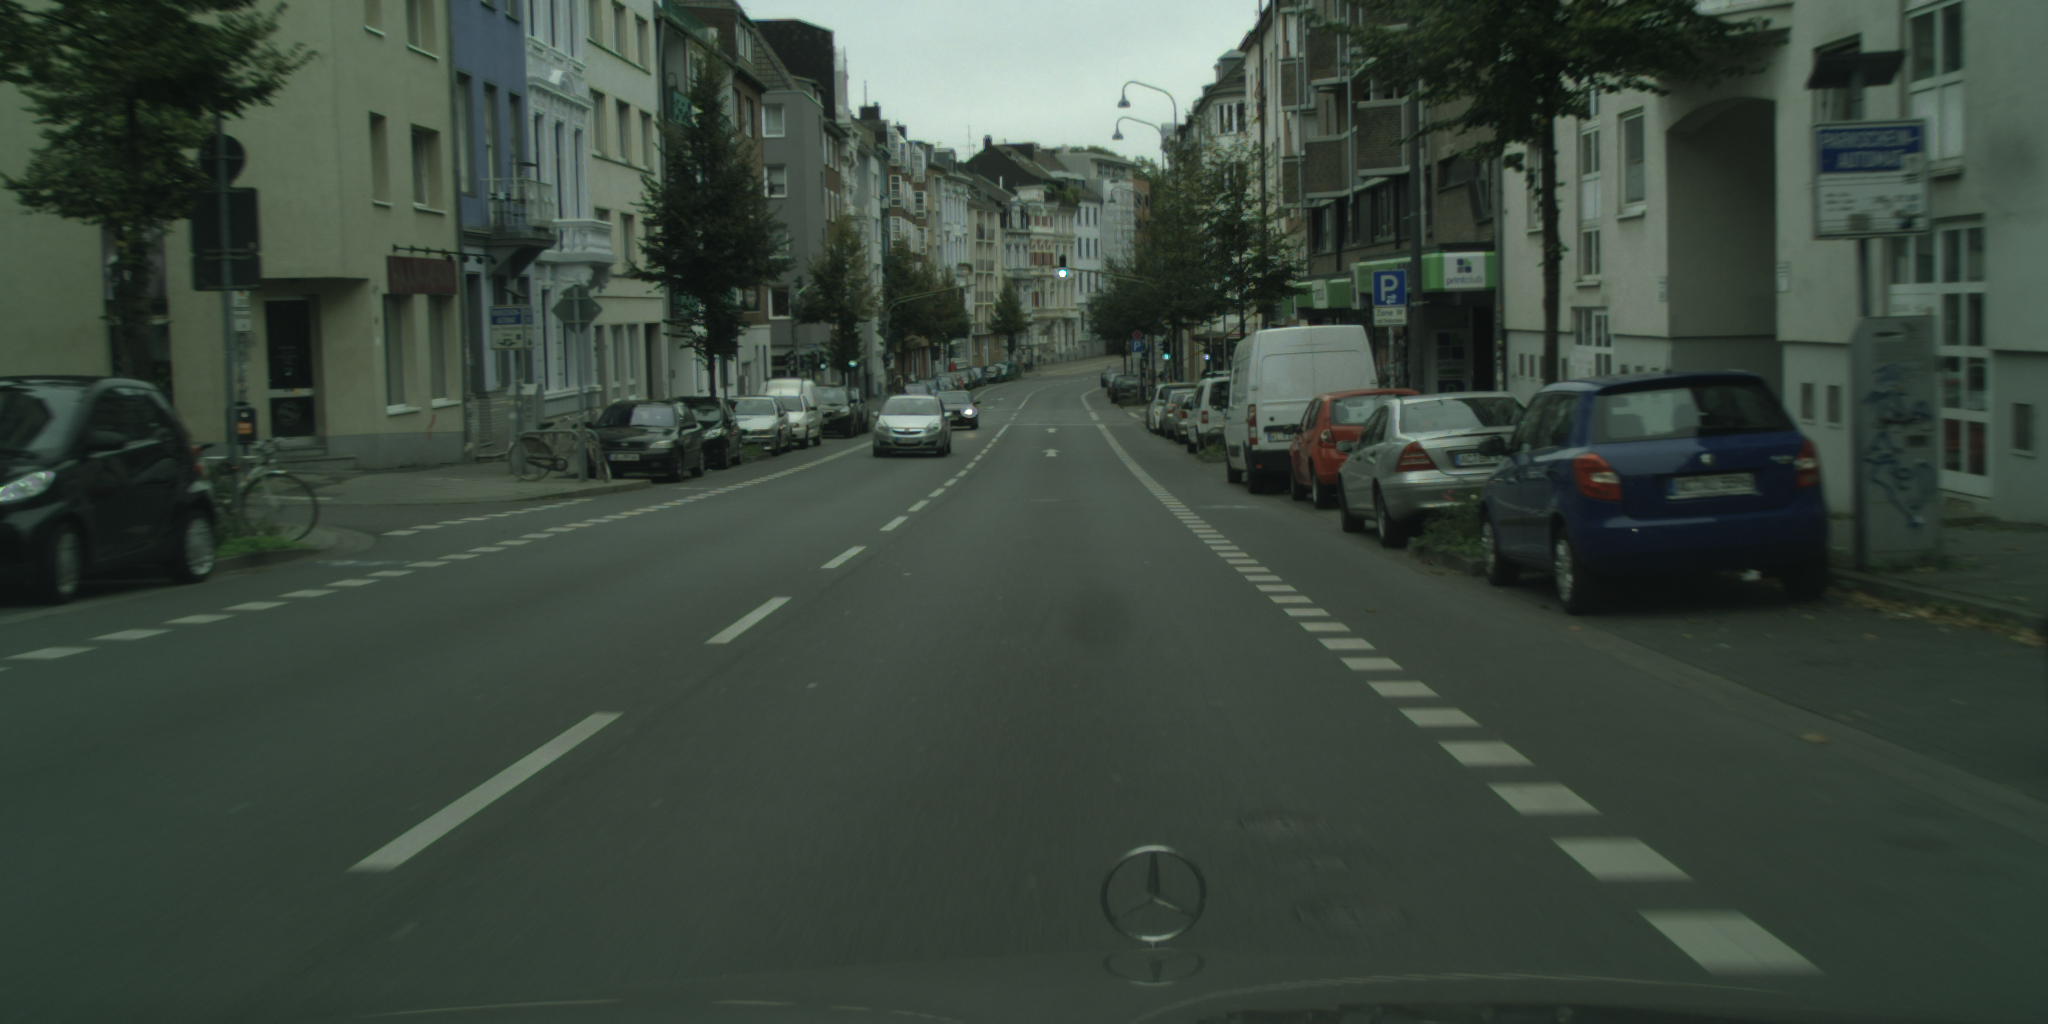

In [17]:
import glob


image_path = glob.glob('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/*.png')
# img = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')
image1 = Image.open(image_path[65])  #65
# image1 = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')  #65


image = np.expand_dims(image1, 0)
image1

In [18]:
seg_map, center_pred, pred_offset = MODEL.run(image)

6.84979701042


In [19]:
# Post-Processing to visualize Outputs 
print(pred_offset.shape)

offset = pred_offset
red, green = np.dsplit(offset, 2)
max_red = np.amax(red)
red = np.multiply(np.divide(red, max_red), 255.0)
max_green = np.amax(green)
green = np.multiply(np.divide(green, max_green), 255.0)
blue = np.zeros_like(red)
offset = np.concatenate((red, green, blue), 2)

print(offset.shape)

original_image = Image.fromarray(seg_map* 255//19)
max_center = np.amax(center_pred)
instance_center = np.multiply(np.divide(center_pred, max_center), 255.0)


(1024, 2048, 2)
(1024, 2048, 3)


In [20]:
def nms_centerpoint_stride(image, kernel_size=16):
    test =np.array(image)
    
    center_dict = {}
    additional_centers = []
    for h in range(test.shape[0] // kernel_size):
        for w in range(test.shape[1] // kernel_size-1):

            local_region = test[h*kernel_size: (h*kernel_size) +kernel_size, w*kernel_size :(w*kernel_size) + kernel_size]
            local_max = np.amax(local_region)
            if local_max > 25.5:
                idx = np.where(test == local_max)
            # Dictionary
                center_dict[local_max] = idx
                
                
    return center_dict


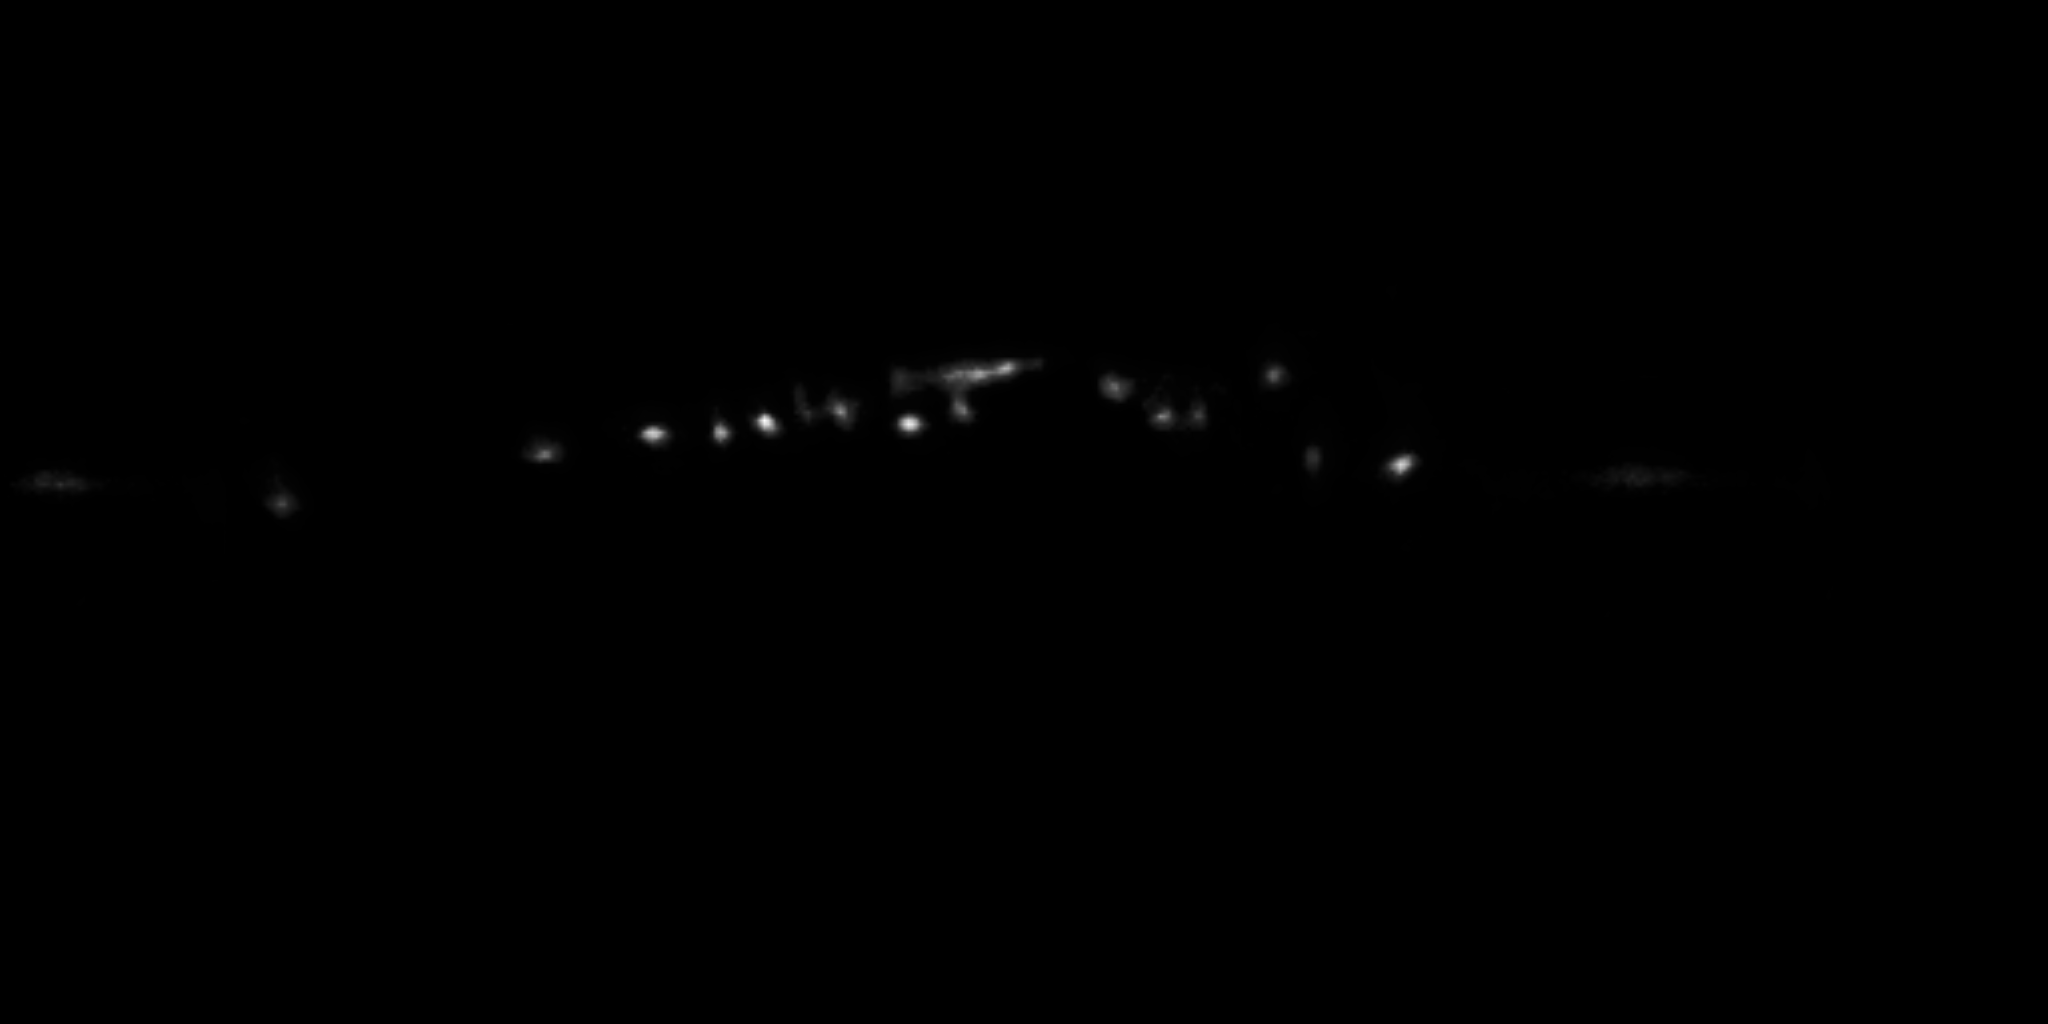

In [21]:
Image.fromarray(instance_center.astype('uint8'))

In [22]:
# Max Pooling Based Non-maxima supression
#center_pred = np.array(Image.open('/mrtstorage/users/rehman/datasets/cityscapes/gt_heatmaps_17x17/train/aachen/aachen_000000_000019_gtFine_instanceIds.png'))

nms_pooling_filer_size = 32
center_dict = nms_centerpoint_stride(instance_center, nms_pooling_filer_size)
print(len(center_dict))
center_dict

54


{26.798546: (array([480]), array([1628])),
 26.89118: (array([384]), array([1272])),
 27.12698: (array([424]), array([895])),
 27.63084: (array([480]), array([1644])),
 27.706505: (array([512]), array([280])),
 29.384897: (array([476]), array([1631])),
 31.83651: (array([476]), array([1632])),
 32.118797: (array([420]), array([1151])),
 32.40484: (array([384]), array([895])),
 33.10956: (array([484]), array([68])),
 33.881756: (array([380]), array([895])),
 33.97049: (array([364]), array([1036])),
 35.29886: (array([504]), array([288])),
 40.005226: (array([447]), array([540])),
 40.32205: (array([416]), array([808])),
 41.40218: (array([436]), array([639])),
 41.466084: (array([447]), array([548])),
 42.799175: (array([456]), array([1311])),
 44.817245: (array([456]), array([1316])),
 44.884533: (array([380]), array([900])),
 48.822403: (array([416]), array([959])),
 49.279686: (array([383]), array([1120])),
 49.345673: (array([372]), array([1280])),
 50.214115: (array([484]), array([

In [23]:
for index, key in enumerate(sorted(center_dict.keys(), reverse=True)):
    print(index, key)

(0, 255.0)
(1, 237.35677)
(2, 216.18854)
(3, 213.04385)
(4, 204.97983)
(5, 176.63715)
(6, 171.73593)
(7, 160.25209)
(8, 146.33382)
(9, 145.87415)
(10, 145.47015)
(11, 133.23926)
(12, 112.376755)
(13, 112.28176)
(14, 110.45654)
(15, 105.49375)
(16, 105.406784)
(17, 105.31417)
(18, 105.27497)
(19, 97.84052)
(20, 89.74778)
(21, 84.37668)
(22, 81.66655)
(23, 77.129)
(24, 71.21153)
(25, 64.162964)
(26, 60.797146)
(27, 58.736183)
(28, 57.878265)
(29, 50.659874)
(30, 50.214115)
(31, 49.345673)
(32, 49.279686)
(33, 48.822403)
(34, 44.884533)
(35, 44.817245)
(36, 42.799175)
(37, 41.466084)
(38, 41.40218)
(39, 40.32205)
(40, 40.005226)
(41, 35.29886)
(42, 33.97049)
(43, 33.881756)
(44, 33.10956)
(45, 32.40484)
(46, 32.118797)
(47, 31.83651)
(48, 29.384897)
(49, 27.706505)
(50, 27.63084)
(51, 27.12698)
(52, 26.89118)
(53, 26.798546)


number of instances_found : 23


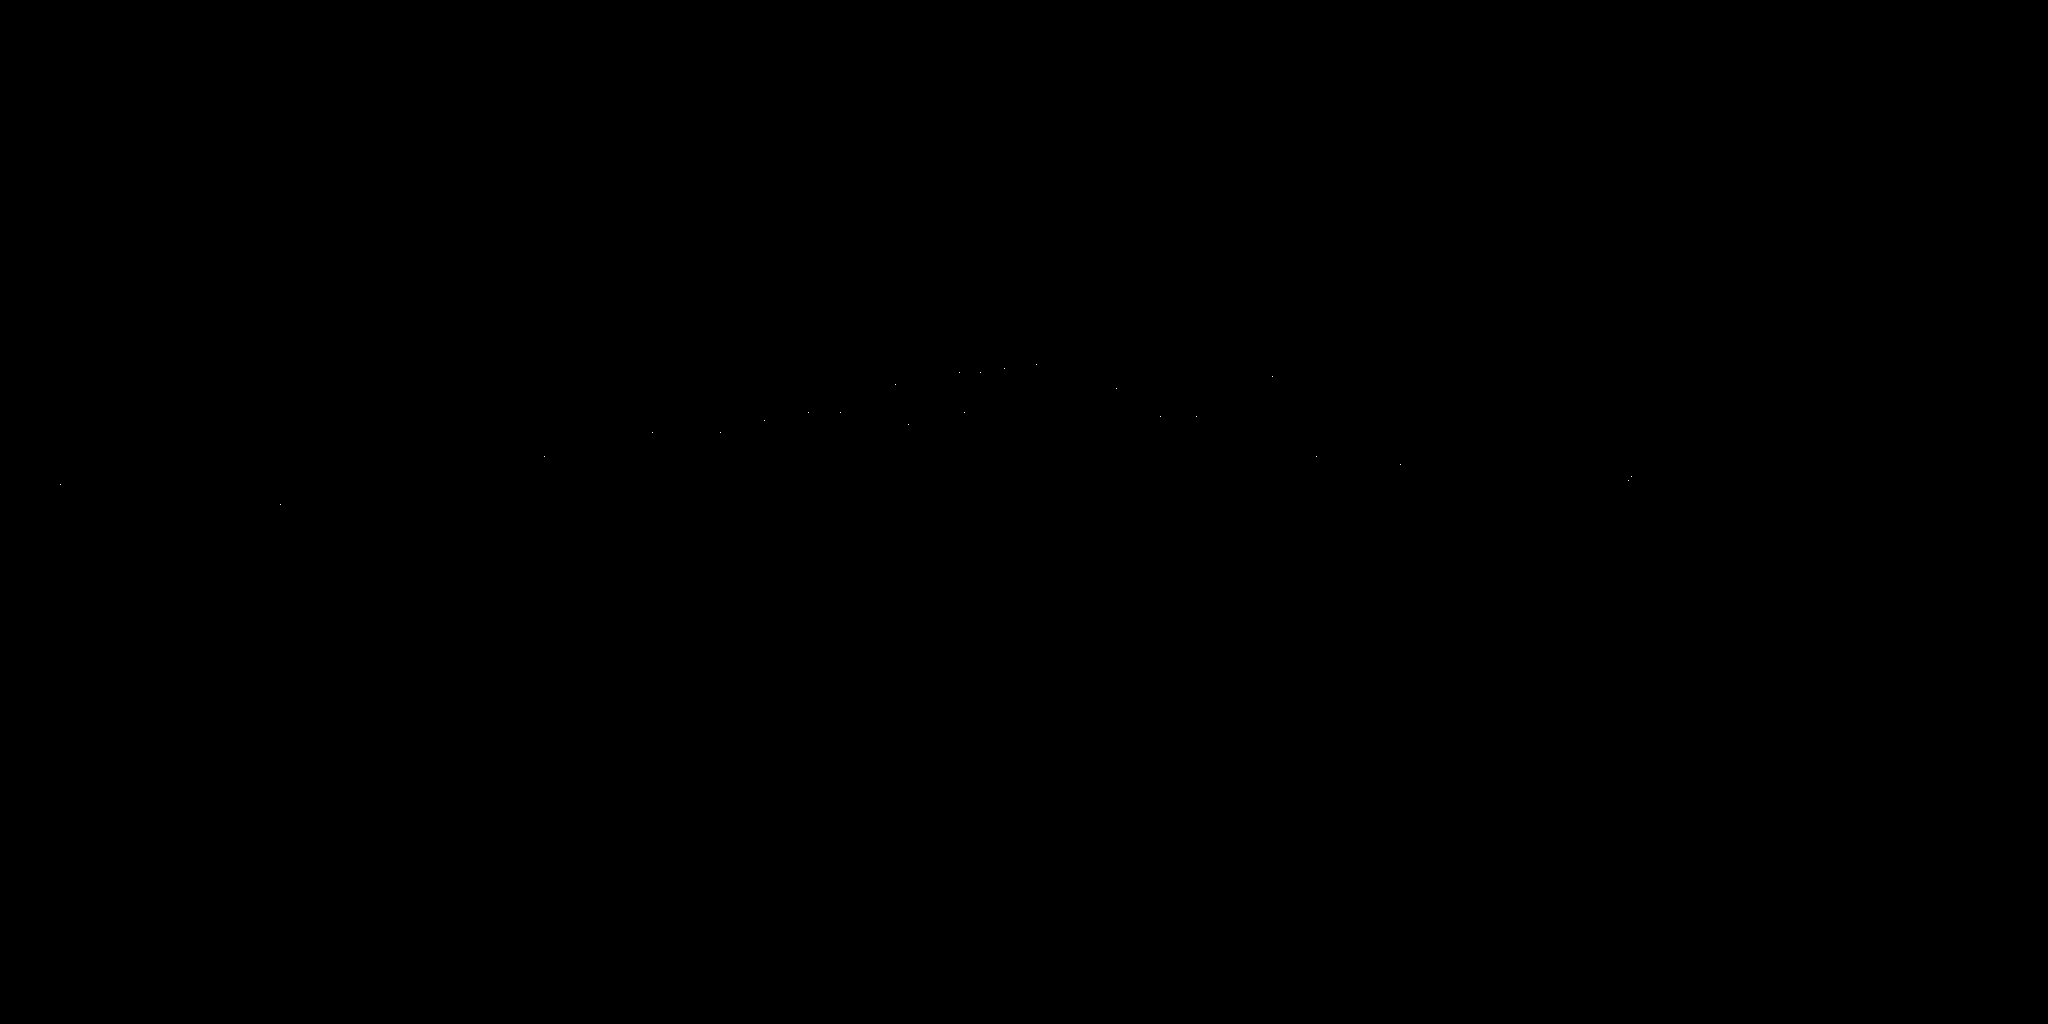

In [24]:
new_array = np.zeros(np.array(instance_center).shape)
center_points = []
for index, key in enumerate(sorted(center_dict.keys(), reverse=True)):
    if index < 200:
        center_points.append(center_dict[key])
instance_resoltion = 16
filtered_centers = center_points
for center in center_points:
    for i, center_x in enumerate(center_points):
        if center_x != center:
            diff_center_h = np.square(np.subtract(center[0], center_x[0]))
            diff_center_w = np.square(np.subtract(center[1], center_x[1]))
            diff_dist = np.sqrt(diff_center_h + diff_center_w)
            if diff_dist < instance_resoltion:
                filtered_centers.pop(i)

print('number of instances_found : {}'.format(len(filtered_centers)))

for center in filtered_centers:
    new_array[center]= 255
Image.fromarray(new_array.astype('uint8'))

Instances : [ 0  1  2  5  6  7  8  9 10 11 13 18]


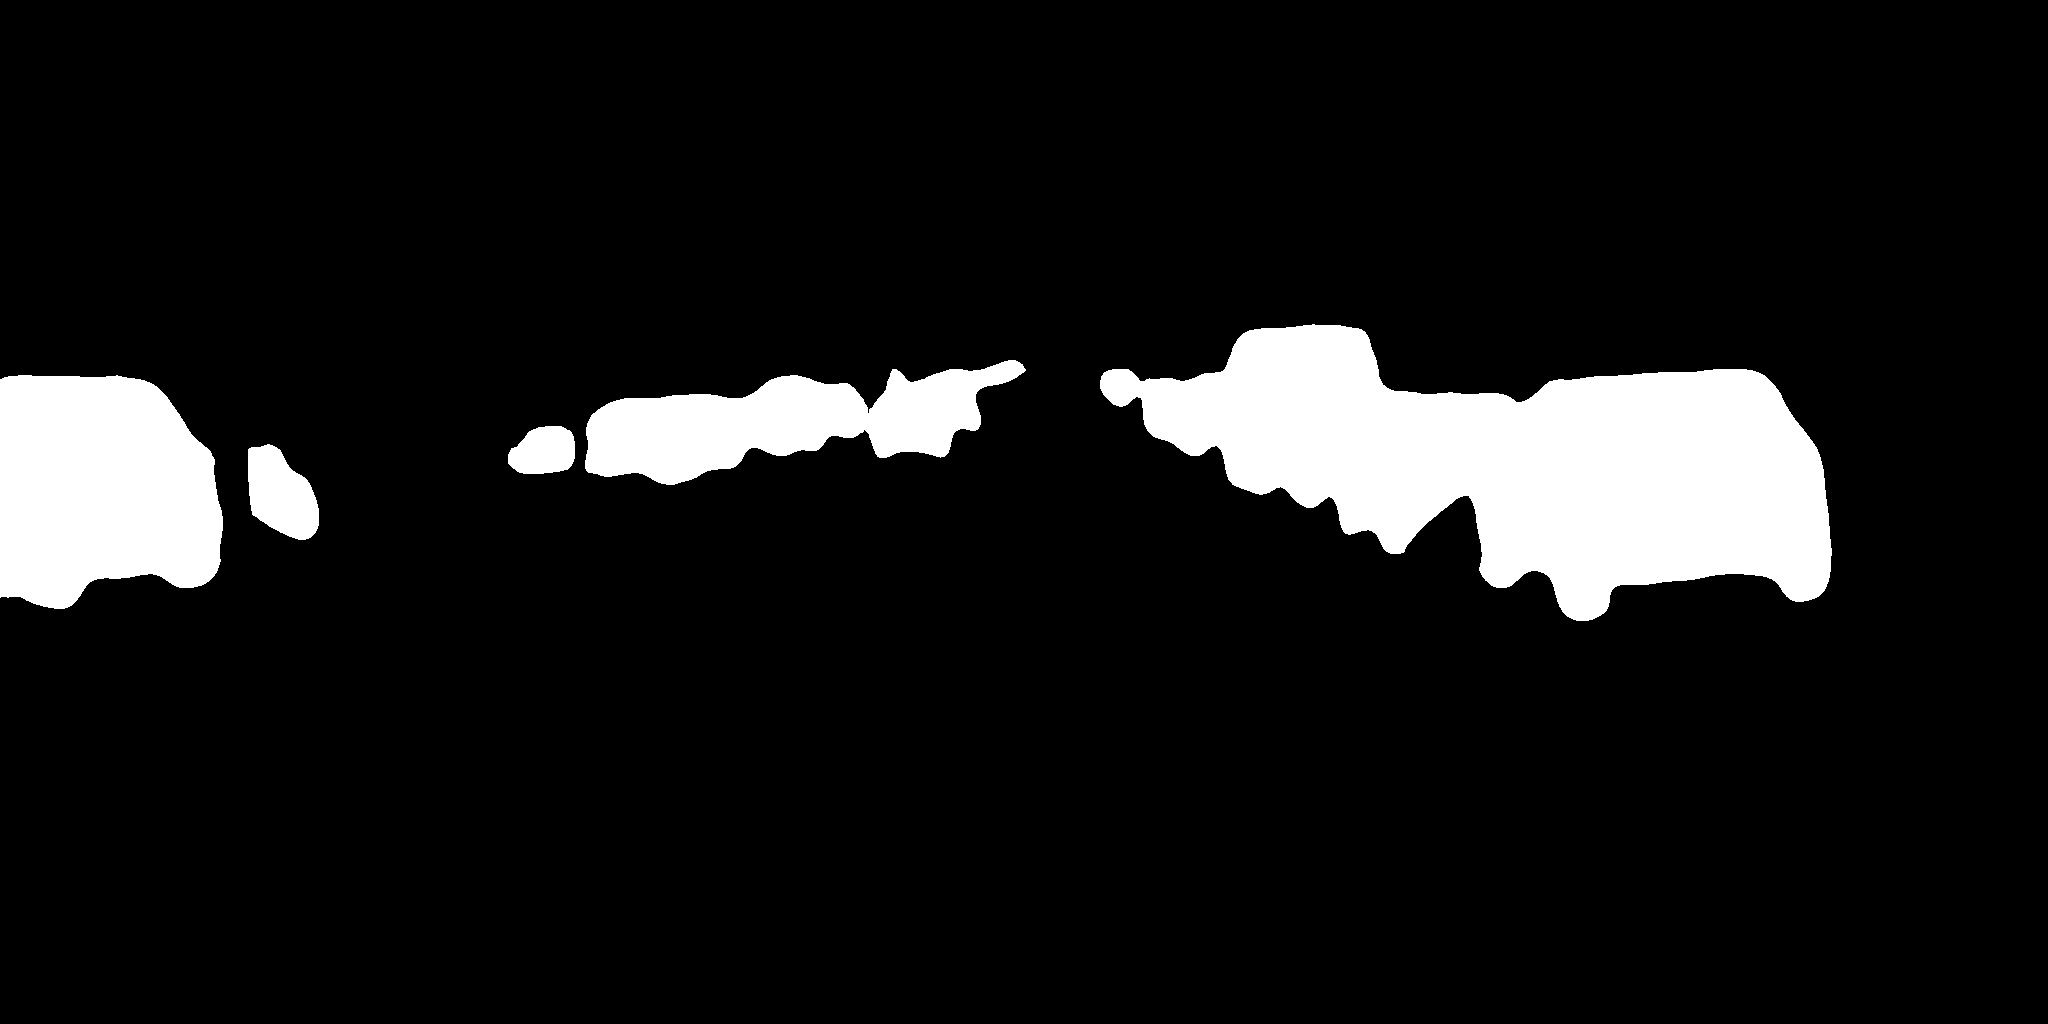

In [25]:
# Mask for Instances from semantic segmentation

semantic_seg_array = seg_map
unique_ids = np.unique(semantic_seg_array)
print('Instances : {}'.format(unique_ids))
instances_in_image = [unique_id for unique_id in unique_ids if(unique_id > 10 and unique_id <= 18)]
panoptic_mask = np.zeros(np.array(seg_map).shape)

for i in range(len(instances_in_image)):
    
    local_mask = semantic_seg_array == instances_in_image[i]
    panoptic_mask += local_mask
    
panoptic_mask = panoptic_mask.astype('bool')

Image.fromarray(panoptic_mask)

In [26]:
# # red = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/gt_offsetvectors_x/train/aachen/aachen_000000_000019_gtFine_instanceIds.png')
# # green = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/gt_offsetvectors_y/train/aachen/aachen_000000_000019_gtFine_instanceIds.png')

# # r, g, b = np.dsplit(np.array(red), 3)
# # red = r+ 256*g 

# # r, g, b = np.dsplit(np.array(green), 3)
# # green = r+ 256*g 

# red, green = np.dsplit(pred_offset, 2)

# x_vectors = np.squeeze(red) * 255
# y_vectors = np.squeeze(green) * 255


# row, col = np.indices(x_vectors.shape)

# stacked_offsets = np.zeros_like(x_vectors) + 2049
# start_time = time.time()
# for center in center_points:
#     h,w = center
    
#     y_vectors[h[0]+1:,:]  *= -1
#     x_vectors[:, w[0]+1:] *= -1
        
#     h_ = np.square(h[0] - np.add(row, y_vectors)) * panoptic_mask
#     w_ =  np.square(w[0] - np.add(col, x_vectors)) * panoptic_mask
#     value = np.sqrt(h_ + w_)
    
#     stacked_offsets = np.dstack((stacked_offsets, value))

# output = np.argmin(stacked_offsets, axis=-1)
# end_time = time.time()

# print(output.shape)
# print(np.amax(output))

# print(end_time - start_time)

# output = output * (255//len(np.unique(output)))


# inst_color = cv2.applyColorMap(output.astype('uint8'), cv2.COLORMAP_JET)
# inst_color = Image.fromarray(inst_color)

# Image.blend(image1, inst_color, 0.4)

In [35]:
# Generate Instance Segmentation 
def assign_id(center, ij, w_vectors, h_vectors):
    h, w = ij 
    index_regression = []
    for i in range(len(center)):

        if (center[i][1] > w):
            index_plus_offset_w = np.add(w, w_vectors[h][w])
        elif (center[i][1] <= w):
            index_plus_offset_w = np.subtract(w, w_vectors[h][w])
        if (center[i][0] > h):
            index_plus_offset_h = np.add(h, h_vectors[h][w])
        elif (center[i][0] <= h):
            index_plus_offset_h = np.subtract(h, h_vectors[h][w])

#         index_plus_offset_w = np.add(w, w_vectors[h][w])
#         index_plus_offset_h = np.add(h, h_vectors[h][w])
            
        index_plus_offset = [index_plus_offset_h, index_plus_offset_w]
        diff_center_h = np.square(np.subtract(center[i][0], index_plus_offset[0]))
        diff_center_w = np.square(np.subtract(center[i][1], index_plus_offset[1]))
        diff_dist = np.square(np.sqrt(np.add(diff_center_h, diff_center_w)))
        index_regression.append(diff_dist)

    x = np.argmin(index_regression)
    return x+1

In [36]:
# Data Preperation
semantic_seg = Image.fromarray(seg_map)
panoptic_segmentation = Image.new('L', semantic_seg.size)
panoptic_segmentation = np.array(panoptic_segmentation)
red, green = np.dsplit(pred_offset, 2)
x_vectors = red * 255
y_vectors = green * 255


for center in filtered_centers:
    panoptic_mask[center] = False


instance_pixels = np.where(panoptic_mask)
instance_pixels = np.array(instance_pixels).transpose()


start = time.time()
print(len(instance_pixels))
for i in range(len(instance_pixels)):
    h, w = instance_pixels[i]   
    panoptic_segmentation[h][w] = assign_id(center_points, [h,w], x_vectors, y_vectors)

end_time = time.time()

panoptic_segmentation_scaled = panoptic_segmentation* (255//len(np.unique(panoptic_segmentation)))
Image.fromarray(panoptic_segmentation_scaled)
print(end_time - start)

196503
56.2589528561


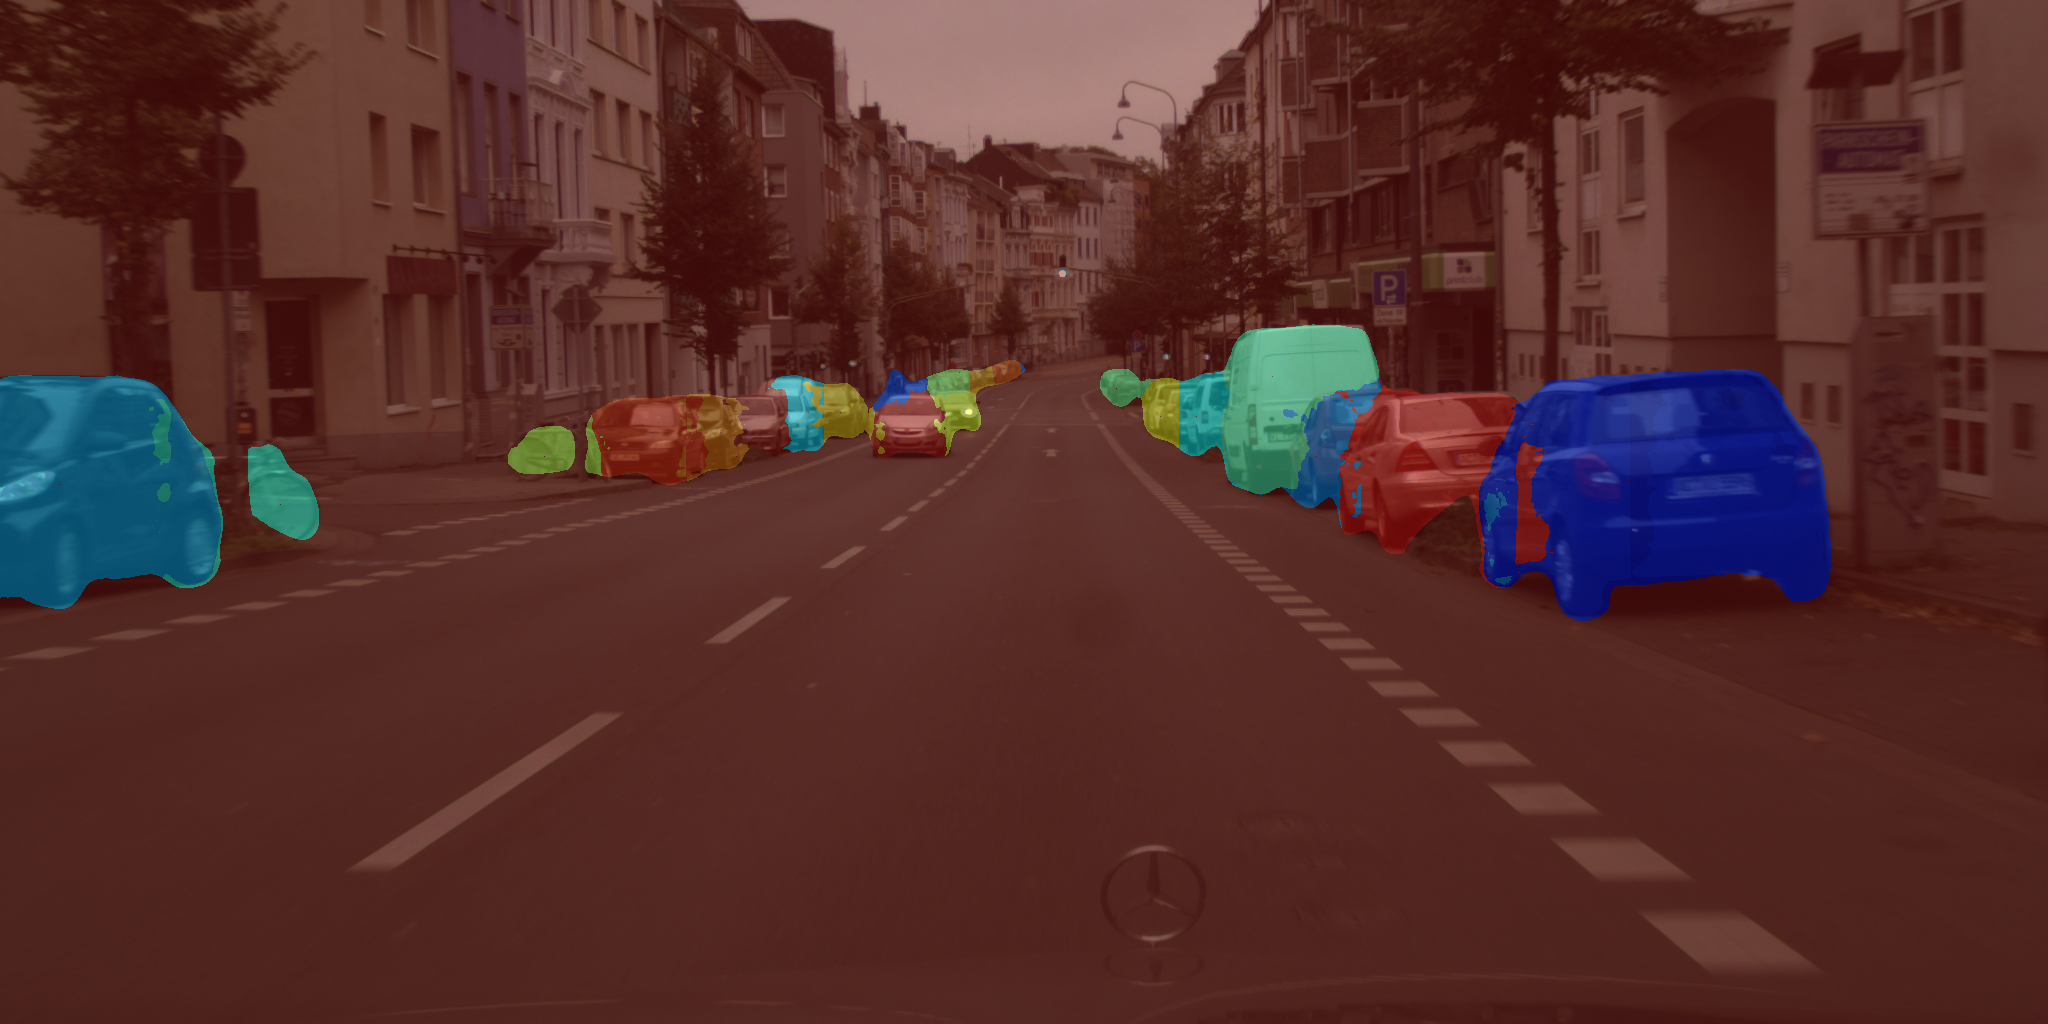

In [37]:
instance_seg_img = Image.fromarray(panoptic_segmentation_scaled)

inst_color = cv2.applyColorMap(panoptic_segmentation_scaled, cv2.COLORMAP_JET)
inst_color = Image.fromarray(inst_color)

Image.blend(image1, inst_color, 0.4)